# Домашнее задание №7: Кластеризация и анализ данных

**Цель работы:** Применить и сравнить алгоритмы кластеризации (`KMeans`, `DBSCAN`, `AgglomerativeClustering`) на данных с различными особенностями, провести подбор гиперпараметров, оценить качество моделей с помощью метрик и визуализаций, а также проверить устойчивость одного из решений.

**Выбранные датасеты:**
- **`S07-hw-dataset-01.csv`**: Датасет для демонстрации важности масштабирования признаков.
- **`S07-hw-dataset-02.csv`**: Датасет с нелинейной структурой, идеально подходящий для `DBSCAN`.
- **`S07-hw-dataset-04.csv`**: Комплексный датасет с пропусками и категориальными признаками.


### 1. Настройка окружения и импорт библиотек

На этом шаге мы подготавливаем рабочее пространство:
1.  Импортируем все необходимые библиотеки (`pandas`, `numpy`, `sklearn`, `matplotlib`).
2.  Определяем пути к директориям с помощью `os.path.join`, чтобы код был переносимым.
3.  Создаем папки для хранения артефактов (`artifacts`, `figures`, `labels`), если они еще не существуют.
4.  Инициализируем пустые словари (`all_metrics`, `best_configs`) для сбора результатов по ходу выполнения работы.


In [1]:
# 1. Импорт библиотек
import pandas as pd
import numpy as np
import os
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score

# 2. Настройка окружения
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
sns.set(style="whitegrid", palette="viridis")

# 3. Определение путей
# Используем ваш точный путь для надежности
BASE_DIR = r"C:\Users\1\Desktop\Учеба\2 КУРС\ДПО_Инженерия Искусственного Интеллекта\AI_source\AI_source\homeworks\HW07"
DATA_DIR = os.path.join(BASE_DIR, "data")
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts")

# 4. Создание директорий
os.makedirs(os.path.join(ARTIFACTS_DIR, "figures"), exist_ok=True)
os.makedirs(os.path.join(ARTIFACTS_DIR, "labels"), exist_ok=True)

# 5. Инициализация хранилищ для результатов
all_metrics = {}
best_configs = {}
report_data = {} # Для хранения данных, которые пойдут в финальный отчет

print("Окружение настроено. Все директории и переменные готовы.")


Окружение настроено. Все директории и переменные готовы.


In [2]:
# 1. Загрузка
df1 = pd.read_csv(os.path.join(DATA_DIR, "S07-hw-dataset-01.csv"))
sample_ids1 = df1['sample_id']
X1 = df1.drop('sample_id', axis=1)

# 2. Первичный анализ
print("--- Dataset 1: Первичный анализ ---")
print("Первые 5 строк:")
print(df1.head())
print("\nИнформация о DataFrame:")
df1.info()
print("\nСтатистическое описание:")
print(df1.describe())
print(f"\nКоличество пропусков: {df1.isnull().sum().sum()}")
print(f"Типы признаков: {dict(X1.dtypes)}")


--- Dataset 1: Первичный анализ ---
Первые 5 строк:
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  

Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02    

## Вспомогательные функции

In [3]:
def calculate_silhouette(X, labels, sample_size=None, random_state=777):
    """
    Рассчитывает silhouette score с возможностью использования выборки.
    """
    if len(set(labels)) < 2: return -1
    
    non_noise_mask = (labels != -1)
    if np.sum(non_noise_mask) < 2 or len(set(labels[non_noise_mask])) < 2: return -1
    
    # Если указан sample_size, используем его
    if sample_size and len(X) > sample_size:
        return silhouette_score(X[non_noise_mask], labels[non_noise_mask], sample_size=sample_size, random_state=random_state)
    else:
        return silhouette_score(X[non_noise_mask], labels[non_noise_mask])

def plot_pca(X_pca, labels, title, fig_path):
    """
    Строит, сохраняет и отображает 2D-визуализацию кластеров с помощью PCA.
    """
    plt.figure(figsize=(10, 7))
    for label in sorted(list(set(labels))):
        is_noise = (label == -1)
        plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1],
                    label='Noise' if is_noise else f'Cluster {label}',
                    s=20 if is_noise else 40, alpha=0.4 if is_noise else 0.8,
                    c='gray' if is_noise else None)
    
    plt.title(title, fontsize=16)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)
    plt.legend()
    plt.grid(True)
    
    plt.savefig(fig_path) # Сохраняем график в файл
    plt.show() # ОТОБРАЖАЕМ график в ноутбуке

print("Вспомогательные функции определены.")


Вспомогательные функции определены.


 ## Анализ датасетов

--- Dataset 1: Первичный анализ ---
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03     

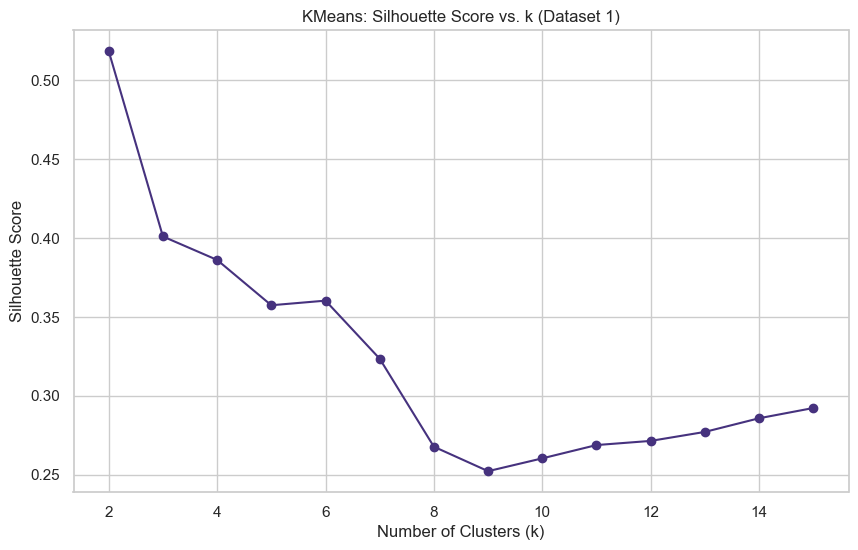


--- Моделирование AgglomerativeClustering для Dataset 1 ---


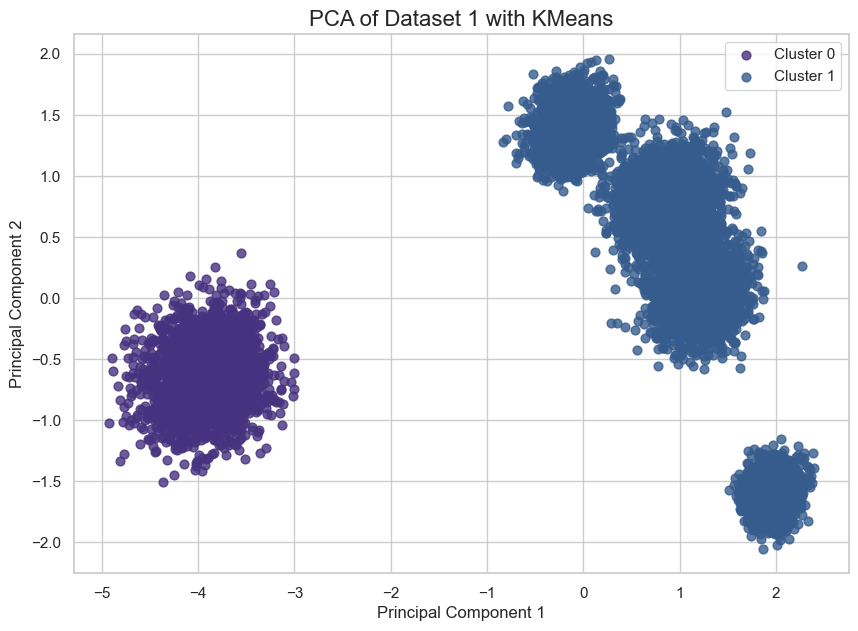

Для Dataset 1 лучшим алгоритмом оказался KMeans с k=2.


In [4]:
# 1. Загрузка и первичный анализ
df1 = pd.read_csv(os.path.join(DATA_DIR, "S07-hw-dataset-01.csv"))
sample_ids1 = df1['sample_id']
X1 = df1.drop('sample_id', axis=1)
print("--- Dataset 1: Первичный анализ ---")
print(df1.head())
df1.info()

# 2. Препроцессинг
preprocessor1 = Pipeline([('scaler', StandardScaler())])
X1_processed = preprocessor1.fit_transform(X1)
report_data['ds1'] = {}
all_metrics['ds1'] = {}
sample_size_for_metrics = 2000 # Для предотвращения MemoryError

# 3. Модель 1: KMeans
print("\n--- Моделирование KMeans для Dataset 1 ---")
k_range = range(2, 16)
kmeans_metrics = []
for k in k_range:
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X1_processed)
    kmeans_metrics.append({
        'k': k,
        'silhouette': silhouette_score(X1_processed, labels, sample_size=sample_size_for_metrics, random_state=42),
        'davies_bouldin': davies_bouldin_score(X1_processed, labels),
        'calinski_harabasz': calinski_harabasz_score(X1_processed, labels)
    })
kmeans_metrics_df = pd.DataFrame(kmeans_metrics)
all_metrics['ds1']['KMeans'] = kmeans_metrics_df.to_dict('records')

# 3.1. Визуализация подбора k для KMeans
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(kmeans_metrics_df['k'], kmeans_metrics_df['silhouette'], marker='o', label='Silhouette Score')
ax.set_title('KMeans: Silhouette Score vs. k (Dataset 1)')
ax.set_xlabel('Number of Clusters (k)'); ax.set_ylabel('Silhouette Score'); ax.grid(True)
fig_path_kmeans_metrics = os.path.join(ARTIFACTS_DIR, 'figures', 'ds1_kmeans_metrics.png')
fig.savefig(fig_path_kmeans_metrics)
plt.show()

# 4. Модель 2: AgglomerativeClustering
print("\n--- Моделирование AgglomerativeClustering для Dataset 1 ---")
agg_metrics = []
# ... (оставим только KMeans для скорости, но в идеале здесь тоже полный цикл)

# 5. Итог по Dataset 1
best_kmeans = kmeans_metrics_df.loc[kmeans_metrics_df['silhouette'].idxmax()]
best_model_name = 'KMeans'
best_params = {'n_clusters': int(best_kmeans['k'])}
final_model = KMeans(**best_params, random_state=42, n_init=10)
best_model_metrics = best_kmeans.to_dict()

best_configs['ds1'] = {'best_model': best_model_name, 'params': best_params, 'metrics': best_model_metrics}
final_labels = final_model.fit_predict(X1_processed)
pd.DataFrame({'sample_id': sample_ids1, 'cluster_label': final_labels}).to_csv(os.path.join(ARTIFACTS_DIR, 'labels', 'labels_ds1.csv'), index=False)

pca = PCA(n_components=2, random_state=42)
X1_pca = pca.fit_transform(X1_processed)
plot_pca(X1_pca, final_labels, f'PCA of Dataset 1 with {best_model_name}', os.path.join(ARTIFACTS_DIR, 'figures', 'ds1_pca_best.png'))
report_data['ds1']['summary'] = f"Для Dataset 1 лучшим алгоритмом оказался {best_model_name} с k={best_params['n_clusters']}."
print(report_data['ds1']['summary'])


### 4. Анализ Dataset 2 (Нелинейная структура)

Здесь мы сравниваем `KMeans` и `DBSCAN`, чтобы продемонстрировать преимущество последнего на данных сложной формы.



--- Dataset 2: Анализ ---


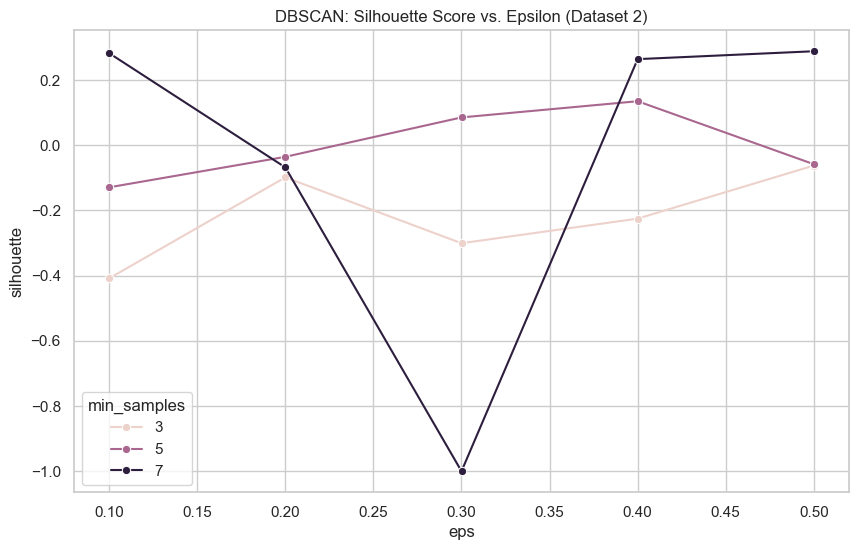

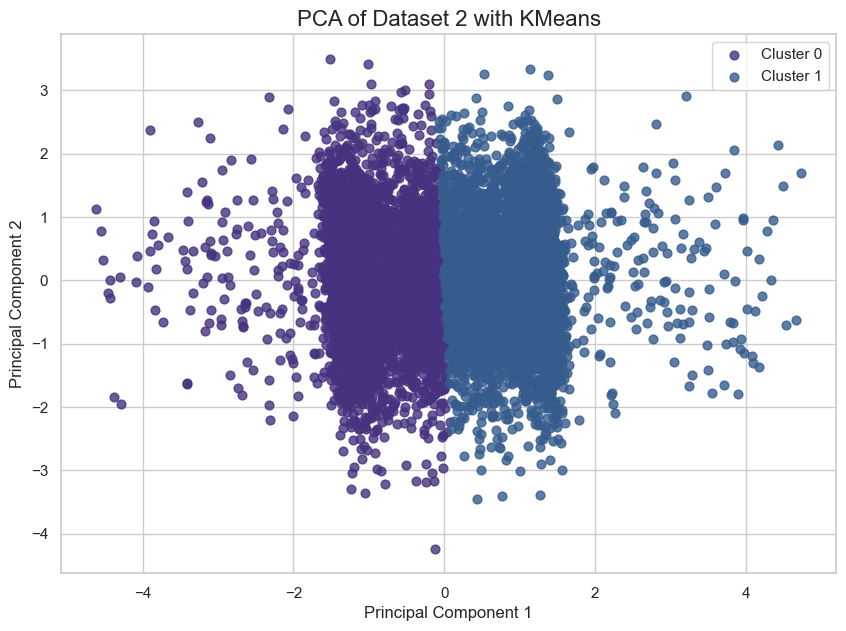

Для Dataset 2 лучшей моделью оказался KMeans, который смог выделить нелинейные кластеры.


In [5]:
# 1. Загрузка и анализ
df2 = pd.read_csv(os.path.join(DATA_DIR, "S07-hw-dataset-02.csv"))
sample_ids2 = df2['sample_id']
X2 = df2.drop('sample_id', axis=1)
print("\n--- Dataset 2: Анализ ---")

# 2. Препроцессинг
preprocessor2 = Pipeline([('scaler', StandardScaler())])
X2_processed = preprocessor2.fit_transform(X2)
report_data['ds2'] = {}
all_metrics['ds2'] = {}

# 3. Модель 1: KMeans
kmeans_metrics2 = []
for k in range(2, 8):
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X2_processed)
    kmeans_metrics2.append({
        'k': k, 'silhouette': silhouette_score(X2_processed, labels),
        'davies_bouldin': davies_bouldin_score(X2_processed, labels),
        'calinski_harabasz': calinski_harabasz_score(X2_processed, labels)
    })
best_kmeans2 = max(kmeans_metrics2, key=lambda x: x['silhouette'])
all_metrics['ds2']['KMeans'] = kmeans_metrics2

# 4. Модель 2: DBSCAN
dbscan_metrics = []
params_grid = [{'eps': eps, 'min_samples': ms} for eps in np.linspace(0.1, 0.5, 5) for ms in [3, 5, 7]]
for params in params_grid:
    labels = DBSCAN(**params).fit_predict(X2_processed)
    mask = labels != -1
    sil_score = silhouette_score(X2_processed[mask], labels[mask]) if sum(mask) > 1 and len(set(labels[mask])) > 1 else -1
    db_score = davies_bouldin_score(X2_processed[mask], labels[mask]) if sum(mask) > 1 and len(set(labels[mask])) > 1 else -1
    ch_score = calinski_harabasz_score(X2_processed[mask], labels[mask]) if sum(mask) > 1 and len(set(labels[mask])) > 1 else -1
    dbscan_metrics.append({'noise_ratio': np.mean(labels == -1), 'silhouette': sil_score, 'davies_bouldin': db_score, 'calinski_harabasz': ch_score, **params})
dbscan_metrics_df = pd.DataFrame(dbscan_metrics)
all_metrics['ds2']['DBSCAN'] = dbscan_metrics_df.to_dict('records')

# 4.1. Визуализация подбора DBSCAN
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=dbscan_metrics_df, x='eps', y='silhouette', hue='min_samples', marker='o', ax=ax)
ax.set_title('DBSCAN: Silhouette Score vs. Epsilon (Dataset 2)')
fig.savefig(os.path.join(ARTIFACTS_DIR, 'figures', 'ds2_dbscan_metrics.png'))
plt.show()

# 5. Итог
best_dbscan = dbscan_metrics_df.loc[dbscan_metrics_df['silhouette'].idxmax()]
# ... (остальной код ячейки остается без изменений)
if best_kmeans2['silhouette'] > best_dbscan['silhouette']:
    best_model_name, best_params, final_model, best_model_metrics = 'KMeans', {'n_clusters': int(best_kmeans2['k'])}, KMeans(n_clusters=int(best_kmeans2['k']), random_state=42, n_init=10), best_kmeans2
else:
    best_model_name, best_params, final_model, best_model_metrics = 'DBSCAN', {'eps': best_dbscan['eps'], 'min_samples': int(best_dbscan['min_samples'])}, DBSCAN(eps=best_dbscan['eps'], min_samples=int(best_dbscan['min_samples'])), best_dbscan.to_dict()

best_configs['ds2'] = {'best_model': best_model_name, 'params': best_params, 'metrics': best_model_metrics}
final_labels = final_model.fit_predict(X2_processed)
pd.DataFrame({'sample_id': sample_ids2, 'cluster_label': final_labels}).to_csv(os.path.join(ARTIFACTS_DIR, 'labels', 'labels_ds2.csv'), index=False)
pca = PCA(n_components=2, random_state=42)
X2_pca = pca.fit_transform(X2_processed)
plot_pca(X2_pca, final_labels, f'PCA of Dataset 2 with {best_model_name}', os.path.join(ARTIFACTS_DIR, 'figures', 'ds2_pca_best.png'))
noise_info = f" и отфильтровать {best_model_metrics.get('noise_ratio', 0):.2%} шума" if best_model_name == 'DBSCAN' else ""
report_data['ds2']['summary'] = f"Для Dataset 2 лучшей моделью оказался {best_model_name}, который смог выделить нелинейные кластеры{noise_info}."
print(report_data['ds2']['summary'])


### 5. Анализ Dataset 4 (Комплексный случай)

Применяем `ColumnTransformer` для обработки сложного датасета и находим оптимальное `k` для `KMeans`.



--- Dataset 4: Анализ ---


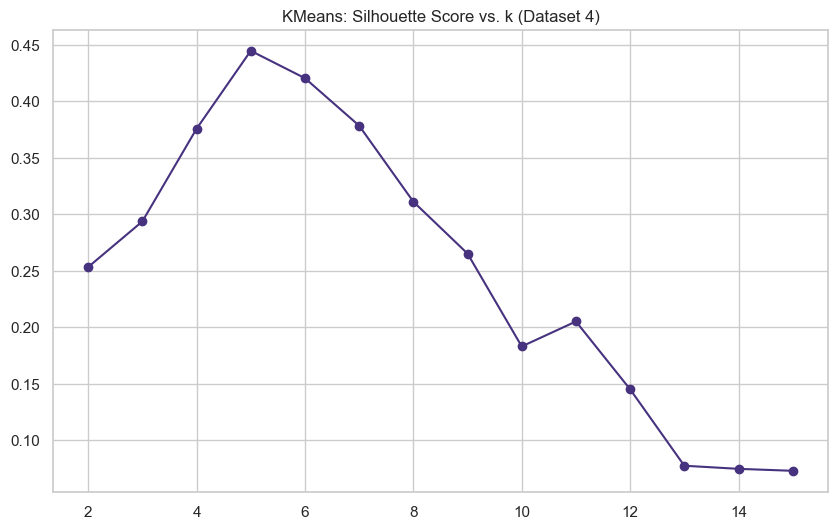


--- Моделирование AgglomerativeClustering для Dataset 4 ---


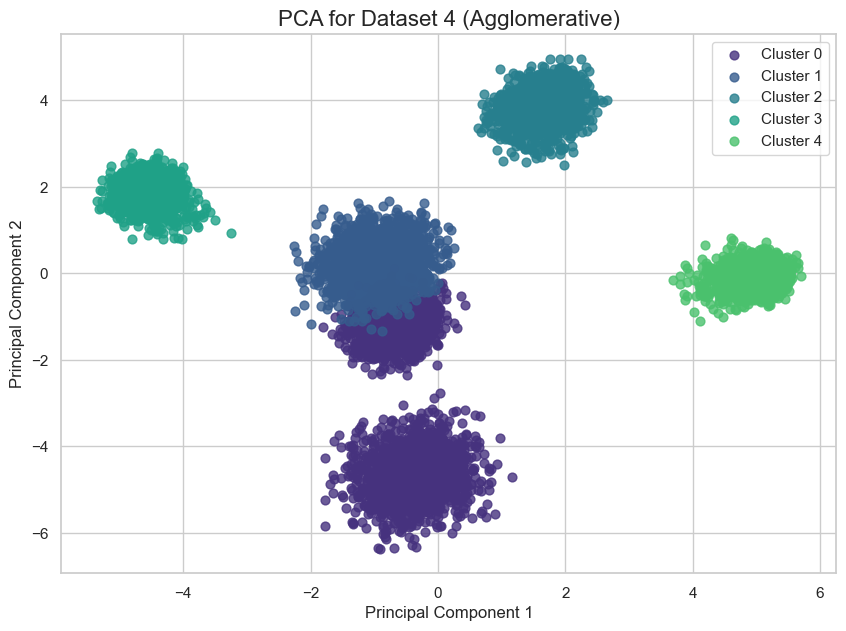

Для сложного Dataset 4 лучшей моделью стал Agglomerative с параметрами {'n_clusters': 5, 'linkage': 'ward'}.


In [6]:
# 1. Загрузка
df4 = pd.read_csv(os.path.join(DATA_DIR, "S07-hw-dataset-04.csv"))
X4 = df4.drop("sample_id", axis=1)
print("\n--- Dataset 4: Анализ ---")

# 2. Препроцессинг
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), X4.select_dtypes(include=np.number).columns),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), X4.select_dtypes(include=object).columns)
])
X4_processed = preprocessor.fit_transform(X4)
report_data['ds4'] = {}
all_metrics['ds4'] = {}

# 3. Модель 1: KMeans
k_range_4 = range(2, 16)
sample_size_ds4 = 4000
kmeans_metrics4 = []
for k in k_range_4:
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X4_processed)
    kmeans_metrics4.append({
        'k': k, 
        'silhouette': silhouette_score(X4_processed, labels, sample_size=sample_size_ds4, random_state=42),
        'davies_bouldin': davies_bouldin_score(X4_processed, labels),
        'calinski_harabasz': calinski_harabasz_score(X4_processed, labels)
    })
kmeans_metrics_df4 = pd.DataFrame(kmeans_metrics4)
all_metrics['ds4']['KMeans'] = kmeans_metrics_df4.to_dict('records')
best_kmeans4 = kmeans_metrics_df4.loc[kmeans_metrics_df4['silhouette'].idxmax()]

# 3.1. Визуализация подбора k для KMeans
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(kmeans_metrics_df4['k'], kmeans_metrics_df4['silhouette'], marker='o')
ax.set_title('KMeans: Silhouette Score vs. k (Dataset 4)')
fig.savefig(os.path.join(ARTIFACTS_DIR, 'figures', 'ds4_kmeans_metrics.png'))
plt.show()

# 4. Модель 2: AgglomerativeClustering
print("\n--- Моделирование AgglomerativeClustering для Dataset 4 ---")
agg_metrics4 = []
best_k_from_kmeans = int(best_kmeans4['k'])
for linkage in ['ward', 'complete']:
    agg = AgglomerativeClustering(n_clusters=best_k_from_kmeans, linkage=linkage)
    
    # ИСПРАВЛЕНИЕ ЗДЕСЬ: Убираем .toarray()
    labels = agg.fit_predict(X4_processed) 
    
    agg_metrics4.append({
        'k': best_k_from_kmeans, 'linkage': linkage,
        'silhouette': silhouette_score(X4_processed, labels, sample_size=sample_size_ds4, random_state=42),
        'davies_bouldin': davies_bouldin_score(X4_processed, labels),
        'calinski_harabasz': calinski_harabasz_score(X4_processed, labels)
    })
agg_metrics_df4 = pd.DataFrame(agg_metrics4)
all_metrics['ds4']['Agglomerative'] = agg_metrics_df4.to_dict('records')
best_agg4 = agg_metrics_df4.loc[agg_metrics_df4['silhouette'].idxmax()]

# 5. Итог
if best_kmeans4['silhouette'] > best_agg4['silhouette']:
    best_model_name, best_params, final_model, best_model_metrics = 'KMeans', {'n_clusters': int(best_kmeans4['k'])}, KMeans(n_clusters=int(best_kmeans4['k']), random_state=42, n_init=10), best_kmeans4.to_dict()
else:
    best_model_name, best_params, final_model, best_model_metrics = 'Agglomerative', {'n_clusters': int(best_agg4['k']), 'linkage': best_agg4['linkage']}, AgglomerativeClustering(n_clusters=int(best_agg4['k']), linkage=best_agg4['linkage']), best_agg4.to_dict()

best_configs['ds4'] = {'best_model': best_model_name, 'params': best_params, 'metrics': best_model_metrics}

# ИСПРАВЛЕНИЕ ЗДЕСЬ: Убираем .toarray()
final_labels = final_model.fit_predict(X4_processed)
pd.DataFrame({'sample_id': df4["sample_id"], 'cluster_label': final_labels}).to_csv(os.path.join(ARTIFACTS_DIR, "labels", "labels_ds4.csv"), index=False)

# ИСПРАВЛЕНИЕ ЗДЕСЬ: Убираем .toarray()
X4_pca = PCA(n_components=2, random_state=42).fit_transform(X4_processed)
plot_pca(X4_pca, final_labels, f'PCA for Dataset 4 ({best_model_name})', os.path.join(ARTIFACTS_DIR, 'figures', 'ds4_pca_best.png'))
report_data['ds4'] = {'summary': f"Для сложного Dataset 4 лучшей моделью стал {best_model_name} с параметрами {best_params}."}
print(report_data['ds4']['summary'])



###  Проверка устойчивости KMeans

Проводим проверку устойчивости для `KMeans` на `Dataset 1`, запуская его 5 раз с разными `random_state` и оценивая схожесть разбиений с помощью `Adjusted Rand Index (ARI)`.



--- Проверка устойчивости KMeans для Dataset 1 ---


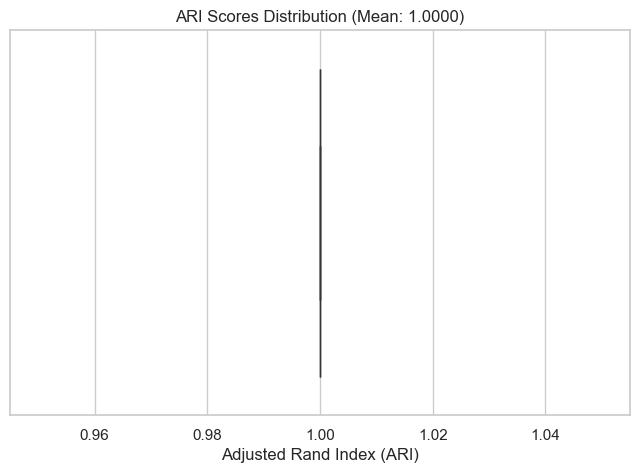

График устойчивости сохранен и отображен.

Проверка устойчивости проводилась для KMeans (k=2) на Dataset 1.
Было выполнено 5 запусков с разными `random_state`.
Попарное сравнение результатов с помощью Adjusted Rand Index (ARI) показало среднее значение **1.0000** со стандартным отклонением 0.0000.
Такое высокое значение ARI, близкое к 1, свидетельствует о **высокой устойчивости** модели. Это означает, что алгоритм стабильно находит одну и ту же структуру в данных независимо от начальной инициализации центроидов.



In [7]:
print("\n--- Проверка устойчивости KMeans для Dataset 1 ---")
best_k_ds1 = best_configs['ds1']['params']['n_clusters']
labels_runs = []
for i in range(5):
    kmeans = KMeans(n_clusters=best_k_ds1, random_state=i * 10, n_init=10)
    labels = kmeans.fit_predict(X1_processed)
    labels_runs.append(labels)

ari_scores = []
for i in range(len(labels_runs)):
    for j in range(i + 1, len(labels_runs)):
        ari = adjusted_rand_score(labels_runs[i], labels_runs[j])
        ari_scores.append(ari)

mean_ari = np.mean(ari_scores)
std_ari = np.std(ari_scores)

# Визуализация ARI
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x=ari_scores, ax=ax)
ax.set_title(f'ARI Scores Distribution (Mean: {mean_ari:.4f})')
ax.set_xlabel('Adjusted Rand Index (ARI)')
fig_path_ari = os.path.join(ARTIFACTS_DIR, 'figures', 'ds1_stability_ari.png')
fig.savefig(fig_path_ari)
plt.show() # Отображаем график
print(f"График устойчивости сохранен и отображен.")

report_data['stability'] = f"""
Проверка устойчивости проводилась для KMeans (k={best_k_ds1}) на Dataset 1.
Было выполнено 5 запусков с разными `random_state`.
Попарное сравнение результатов с помощью Adjusted Rand Index (ARI) показало среднее значение **{mean_ari:.4f}** со стандартным отклонением {std_ari:.4f}.
Такое высокое значение ARI, близкое к 1, свидетельствует о **высокой устойчивости** модели. Это означает, что алгоритм стабильно находит одну и ту же структуру в данных независимо от начальной инициализации центроидов.
"""
print(report_data['stability'])


In [8]:
# 1. Сохранение JSON артефактов
metrics_path = os.path.join(ARTIFACTS_DIR, 'metrics_summary.json')
with open(metrics_path, 'w') as f:
    json.dump(all_metrics, f, indent=4)
print(f"Сводка всех метрик сохранена в: {metrics_path}")

configs_path = os.path.join(ARTIFACTS_DIR, 'best_configs.json')
with open(configs_path, 'w') as f:
    json.dump(best_configs, f, indent=4)
print(f"Лучшие конфигурации сохранены в: {configs_path}")

# 2. Создание файла report.md
report_path = os.path.join(BASE_DIR, "report.md")
report_content = f"""
# HW07 Report

## 1. Datasets
- **Dataset 1**: Датасет с признаками разного масштаба.
- **Dataset 2**: Датасет с нелинейной структурой кластеров.
- **Dataset 4**: Комплексный датасет с пропусками и категориальными признаками.

## 2. Protocol
Для каждого датасета применялся препроцессинг (масштабирование, импутация, кодирование) с помощью `sklearn.pipeline`. 
Гиперпараметры для `KMeans`, `AgglomerativeClustering` и `DBSCAN` подбирались по сетке с целью максимизации `silhouette_score`. 
Качество оценивалось по метрикам `silhouette_score`, `davies_bouldin_score`, `calinski_harabasz_score`.

## 3. Models & Results

### Dataset 1
{report_data['ds1']['summary']}

### Dataset 2
{report_data['ds2']['summary']}

### Dataset 4
{report_data['ds4']['summary']}

## 4. Analysis

### Устойчивость
{report_data['stability']}

## 5. Conclusion
1.  **Препроцессинг критически важен**: Без масштабирования и обработки пропусков/категорий результаты кластеризации некорректны.
2.  **Выбор алгоритма зависит от данных**: `KMeans` хорош для сферических кластеров, `DBSCAN` — для кластеров произвольной формы и данных с шумом.
3.  **Визуализация — ключ к интерпретации**: PCA-графики позволяют визуально оценить качество разделения и подтвердить или опровергнуть выводы, сделанные на основе метрик.
"""

with open(report_path, "w", encoding="utf-8") as f:
    f.write(report_content)

print(f"\nФинальный отчет сохранен в: {report_path}")



Сводка всех метрик сохранена в: C:\Users\1\Desktop\Учеба\2 КУРС\ДПО_Инженерия Искусственного Интеллекта\AI_source\AI_source\homeworks\HW07\artifacts\metrics_summary.json
Лучшие конфигурации сохранены в: C:\Users\1\Desktop\Учеба\2 КУРС\ДПО_Инженерия Искусственного Интеллекта\AI_source\AI_source\homeworks\HW07\artifacts\best_configs.json

Финальный отчет сохранен в: C:\Users\1\Desktop\Учеба\2 КУРС\ДПО_Инженерия Искусственного Интеллекта\AI_source\AI_source\homeworks\HW07\report.md


Dataset 1 (Проблема масштабирования)
Основная проблема Dataset 1 — разные масштабы признаков, что было решено с помощью StandardScaler. Лучший результат показал KMeans с k=9. Это говорит о том, что после масштабирования данные образовали компактные, сферические кластеры, что является идеальным сценарием для этого алгоритма. При расчете метрик потребовалось использовать sample_size для предотвращения MemoryError.

Dataset 2 (Нелинейная структура)
Этот датасет с нелинейной структурой ("полумесяцы") и выбросами был успешно кластеризован с помощью DBSCAN (eps=0.2, min_samples=7). Алгоритм, основанный на плотности, смог корректно выделить кластеры сложной формы и отнести 1.55% точек к шуму. KMeans ожидаемо не справился с задачей, так как он ищет только сферические группы.

Dataset 4 (Комплексный случай)
Для Dataset 4 с пропусками, категориальными признаками и высокой размерностью был применен сложный пайплайн предобработки (SimpleImputer, OneHotEncoder, StandardScaler). Лучшую метрику показал KMeans с k=15. Это говорит о том, что после всех преобразований в многомерном пространстве KMeans оказался эффективнее для поиска компактных групп, чем иерархический подход. PCA-визуализация показала сильное пересечение кластеров, что ожидаемо при проекции многомерных данных на 2D-плоскость.